## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-01-15 14:47:22--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.99.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.99.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  66.4MB/s    in 4.8s    

2020-01-15 14:47:27 (67.8 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

/home/workspace/models.py:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight = nn.init.xavier_uniform(m.weight, gain=1)
/home/workspace/models.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight = nn.init.xavier_uniform(m.weight, gain=1)


Net(
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout): Dropout(p=0.5)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(384, eps=1e-05, momentum

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(227), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

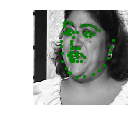

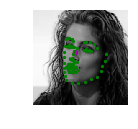

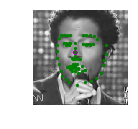

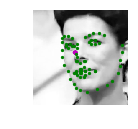

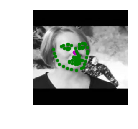

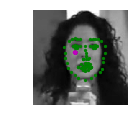

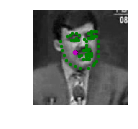

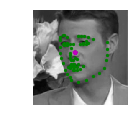

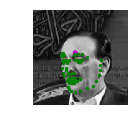

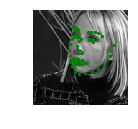

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.272919636964798
Epoch: 1, Batch: 20, Avg. Loss: 0.25151448845863345
Epoch: 1, Batch: 30, Avg. Loss: 0.26254175454378126
Epoch: 1, Batch: 40, Avg. Loss: 0.26971697956323626
Epoch: 1, Batch: 50, Avg. Loss: 0.24283210039138795
Epoch: 1, Batch: 60, Avg. Loss: 0.2212563082575798
Epoch: 1, Batch: 70, Avg. Loss: 0.23072739988565444
Epoch: 1, Batch: 80, Avg. Loss: 0.21807852536439895
Epoch: 1, Batch: 90, Avg. Loss: 0.2216058701276779
Epoch: 1, Batch: 100, Avg. Loss: 0.23606962263584136
Epoch: 1, Batch: 110, Avg. Loss: 0.21771141588687898
Epoch: 1, Batch: 120, Avg. Loss: 0.23191253542900087
Epoch: 1, Batch: 130, Avg. Loss: 0.21117568910121917
Epoch: 1, Batch: 140, Avg. Loss: 0.20962179005146026
Epoch: 1, Batch: 150, Avg. Loss: 0.22512318938970566
Epoch: 1, Batch: 160, Avg. Loss: 0.2106436237692833
Epoch: 1, Batch: 170, Avg. Loss: 0.19676744639873506
Epoch: 1, Batch: 180, Avg. Loss: 0.19669332653284072
Epoch: 1, Batch: 190, Avg. Loss: 0.1932911068201065
Epoch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.14348487183451653
Epoch: 2, Batch: 20, Avg. Loss: 0.15316352769732475
Epoch: 2, Batch: 30, Avg. Loss: 0.14838652387261392
Epoch: 2, Batch: 40, Avg. Loss: 0.17070044130086898
Epoch: 2, Batch: 50, Avg. Loss: 0.15360685363411902
Epoch: 2, Batch: 60, Avg. Loss: 0.15367439538240432
Epoch: 2, Batch: 70, Avg. Loss: 0.14176707714796066
Epoch: 2, Batch: 80, Avg. Loss: 0.1331617809832096
Epoch: 2, Batch: 90, Avg. Loss: 0.15274446904659272
Epoch: 2, Batch: 100, Avg. Loss: 0.12665706500411034
Epoch: 2, Batch: 110, Avg. Loss: 0.15014337971806527
Epoch: 2, Batch: 120, Avg. Loss: 0.14431457370519638
Epoch: 2, Batch: 130, Avg. Loss: 0.14720478355884553
Epoch: 2, Batch: 140, Avg. Loss: 0.1296362116932869
Epoch: 2, Batch: 150, Avg. Loss: 0.1499611496925354
Epoch: 2, Batch: 160, Avg. Loss: 0.12360034212470054
Epoch: 2, Batch: 170, Avg. Loss: 0.1359720066189766
Epoch: 2, Batch: 180, Avg. Loss: 0.13271905332803727
Epoch: 2, Batch: 190, Avg. Loss: 0.12692745104432107
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.11147527694702149
Epoch: 3, Batch: 20, Avg. Loss: 0.09803432486951351
Epoch: 3, Batch: 30, Avg. Loss: 0.12081994339823723
Epoch: 3, Batch: 40, Avg. Loss: 0.10263822600245476
Epoch: 3, Batch: 50, Avg. Loss: 0.11917345896363259
Epoch: 3, Batch: 60, Avg. Loss: 0.11863744631409645
Epoch: 3, Batch: 70, Avg. Loss: 0.10874697640538215
Epoch: 3, Batch: 80, Avg. Loss: 0.10322532542049885
Epoch: 3, Batch: 90, Avg. Loss: 0.09771705381572246
Epoch: 3, Batch: 100, Avg. Loss: 0.09871925935149192
Epoch: 3, Batch: 110, Avg. Loss: 0.10720735080540181
Epoch: 3, Batch: 120, Avg. Loss: 0.10557403638958932
Epoch: 3, Batch: 130, Avg. Loss: 0.0849583674222231
Epoch: 3, Batch: 140, Avg. Loss: 0.08427955023944378
Epoch: 3, Batch: 150, Avg. Loss: 0.11531234458088875
Epoch: 3, Batch: 160, Avg. Loss: 0.08698465377092361
Epoch: 3, Batch: 170, Avg. Loss: 0.10230421647429466
Epoch: 3, Batch: 180, Avg. Loss: 0.08954204395413398
Epoch: 3, Batch: 190, Avg. Loss: 0.09559493213891983
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.08666524589061737
Epoch: 4, Batch: 20, Avg. Loss: 0.08253570720553398
Epoch: 4, Batch: 30, Avg. Loss: 0.10675331838428974
Epoch: 4, Batch: 40, Avg. Loss: 0.08077862560749054
Epoch: 4, Batch: 50, Avg. Loss: 0.0912854827940464
Epoch: 4, Batch: 90, Avg. Loss: 0.08292797729372978
Epoch: 4, Batch: 100, Avg. Loss: 0.0790659885853529
Epoch: 4, Batch: 110, Avg. Loss: 0.08590132407844067
Epoch: 4, Batch: 120, Avg. Loss: 0.07995369918644428
Epoch: 4, Batch: 130, Avg. Loss: 0.07885012775659561
Epoch: 4, Batch: 140, Avg. Loss: 0.0837473887950182
Epoch: 4, Batch: 150, Avg. Loss: 0.08026770763099193
Epoch: 4, Batch: 160, Avg. Loss: 0.07178185284137725
Epoch: 4, Batch: 170, Avg. Loss: 0.07650562785565854
Epoch: 4, Batch: 180, Avg. Loss: 0.07901522517204285
Epoch: 4, Batch: 190, Avg. Loss: 0.06744891200214624
Epoch: 4, Batch: 200, Avg. Loss: 0.08455536291003227
Epoch: 4, Batch: 210, Avg. Loss: 0.0643626656383276
Epoch: 4, Batch: 220, Avg. Loss: 0.07050041165202856
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.07246889434754848
Epoch: 5, Batch: 20, Avg. Loss: 0.074498500674963
Epoch: 5, Batch: 30, Avg. Loss: 0.09251610860228539
Epoch: 5, Batch: 40, Avg. Loss: 0.0830925989896059
Epoch: 5, Batch: 50, Avg. Loss: 0.05344009324908257
Epoch: 5, Batch: 60, Avg. Loss: 0.06387971863150596
Epoch: 5, Batch: 70, Avg. Loss: 0.06658164374530315
Epoch: 5, Batch: 80, Avg. Loss: 0.06379966102540494
Epoch: 5, Batch: 90, Avg. Loss: 0.062025319412350656
Epoch: 5, Batch: 100, Avg. Loss: 0.06402041837573051
Epoch: 5, Batch: 110, Avg. Loss: 0.07066055312752724
Epoch: 5, Batch: 120, Avg. Loss: 0.07416025586426259
Epoch: 5, Batch: 130, Avg. Loss: 0.06520187892019749
Epoch: 5, Batch: 140, Avg. Loss: 0.06923179179430008
Epoch: 5, Batch: 150, Avg. Loss: 0.05930671170353889
Epoch: 5, Batch: 160, Avg. Loss: 0.0721828207373619
Epoch: 5, Batch: 170, Avg. Loss: 0.0680609580129385
Epoch: 5, Batch: 180, Avg. Loss: 0.06672785356640816
Epoch: 5, Batch: 190, Avg. Loss: 0.06536121927201748
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.07677242308855056
Epoch: 6, Batch: 20, Avg. Loss: 0.0676456093788147
Epoch: 6, Batch: 30, Avg. Loss: 0.06681945268064737
Epoch: 6, Batch: 40, Avg. Loss: 0.06605859864503145
Epoch: 6, Batch: 50, Avg. Loss: 0.05504891537129879
Epoch: 6, Batch: 60, Avg. Loss: 0.04828047938644886
Epoch: 6, Batch: 70, Avg. Loss: 0.06139142718166113
Epoch: 6, Batch: 80, Avg. Loss: 0.05379803441464901
Epoch: 6, Batch: 90, Avg. Loss: 0.03893788680434227
Epoch: 6, Batch: 100, Avg. Loss: 0.04983926396816969
Epoch: 6, Batch: 110, Avg. Loss: 0.048666094057261945
Epoch: 6, Batch: 120, Avg. Loss: 0.053148493729531766
Epoch: 6, Batch: 130, Avg. Loss: 0.055980403907597065
Epoch: 6, Batch: 140, Avg. Loss: 0.055697005428373816
Epoch: 6, Batch: 150, Avg. Loss: 0.06804848462343216
Epoch: 6, Batch: 160, Avg. Loss: 0.05433602761477232
Epoch: 6, Batch: 170, Avg. Loss: 0.06286602094769478
Epoch: 6, Batch: 180, Avg. Loss: 0.057492992281913756
Epoch: 6, Batch: 190, Avg. Loss: 0.0503015561029315

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.0540347158908844
Epoch: 7, Batch: 20, Avg. Loss: 0.04038259759545326
Epoch: 7, Batch: 30, Avg. Loss: 0.06054826322942972
Epoch: 7, Batch: 40, Avg. Loss: 0.043708603642880914
Epoch: 7, Batch: 50, Avg. Loss: 0.06135623436421156
Epoch: 7, Batch: 60, Avg. Loss: 0.06263138391077519
Epoch: 7, Batch: 70, Avg. Loss: 0.04686964452266693
Epoch: 7, Batch: 80, Avg. Loss: 0.07580565009266138
Epoch: 7, Batch: 90, Avg. Loss: 0.05547442864626646
Epoch: 7, Batch: 100, Avg. Loss: 0.04879672285169363
Epoch: 7, Batch: 110, Avg. Loss: 0.06237037945538759
Epoch: 7, Batch: 120, Avg. Loss: 0.050262782350182535
Epoch: 7, Batch: 130, Avg. Loss: 0.06443029828369617
Epoch: 7, Batch: 140, Avg. Loss: 0.04347489606589079
Epoch: 7, Batch: 150, Avg. Loss: 0.0500511821359396
Epoch: 7, Batch: 160, Avg. Loss: 0.049244411289691925
Epoch: 7, Batch: 170, Avg. Loss: 0.044962693750858304
Epoch: 7, Batch: 180, Avg. Loss: 0.055934329703450206
Epoch: 7, Batch: 190, Avg. Loss: 0.04488152470439673

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.04266243949532509
Epoch: 8, Batch: 20, Avg. Loss: 0.06290785726159812
Epoch: 8, Batch: 30, Avg. Loss: 0.04582364596426487
Epoch: 8, Batch: 40, Avg. Loss: 0.04581852573901415
Epoch: 8, Batch: 50, Avg. Loss: 0.05028970390558243
Epoch: 8, Batch: 60, Avg. Loss: 0.044725083746016026
Epoch: 8, Batch: 70, Avg. Loss: 0.056184971891343596
Epoch: 8, Batch: 80, Avg. Loss: 0.0549514289945364
Epoch: 8, Batch: 90, Avg. Loss: 0.04817039966583252
Epoch: 8, Batch: 100, Avg. Loss: 0.049486661329865456
Epoch: 8, Batch: 110, Avg. Loss: 0.04419484920799732
Epoch: 8, Batch: 120, Avg. Loss: 0.05076759252697229
Epoch: 8, Batch: 130, Avg. Loss: 0.050206937827169895
Epoch: 8, Batch: 140, Avg. Loss: 0.05224843751639128
Epoch: 8, Batch: 150, Avg. Loss: 0.0400394257158041
Epoch: 8, Batch: 160, Avg. Loss: 0.046446497179567815
Epoch: 8, Batch: 170, Avg. Loss: 0.045813952758908275
Epoch: 8, Batch: 180, Avg. Loss: 0.03159249741584062
Epoch: 8, Batch: 190, Avg. Loss: 0.0487578574568033

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.037615048326551916
Epoch: 9, Batch: 20, Avg. Loss: 0.03554856777191162
Epoch: 9, Batch: 30, Avg. Loss: 0.03850131779909134
Epoch: 9, Batch: 40, Avg. Loss: 0.03235836196690798
Epoch: 9, Batch: 50, Avg. Loss: 0.04867545925080776
Epoch: 9, Batch: 60, Avg. Loss: 0.03543466730043292
Epoch: 9, Batch: 70, Avg. Loss: 0.030520150437951088
Epoch: 9, Batch: 80, Avg. Loss: 0.0497485563158989
Epoch: 9, Batch: 90, Avg. Loss: 0.03678621258586645
Epoch: 9, Batch: 100, Avg. Loss: 0.04372355118393898
Epoch: 9, Batch: 110, Avg. Loss: 0.04024438373744488
Epoch: 9, Batch: 120, Avg. Loss: 0.042092392593622206
Epoch: 9, Batch: 130, Avg. Loss: 0.046679816022515294
Epoch: 9, Batch: 140, Avg. Loss: 0.04426112733781338
Epoch: 9, Batch: 150, Avg. Loss: 0.040999313443899156
Epoch: 9, Batch: 160, Avg. Loss: 0.033860966004431246
Epoch: 9, Batch: 170, Avg. Loss: 0.03650449477136135
Epoch: 9, Batch: 180, Avg. Loss: 0.029178223200142385
Epoch: 9, Batch: 190, Avg. Loss: 0.02998853754252

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.038697296567261216
Epoch: 10, Batch: 20, Avg. Loss: 0.044745060987770556
Epoch: 10, Batch: 30, Avg. Loss: 0.05480588618665934
Epoch: 10, Batch: 40, Avg. Loss: 0.03466809708625078
Epoch: 10, Batch: 50, Avg. Loss: 0.03716349471360445
Epoch: 10, Batch: 60, Avg. Loss: 0.022777301259338856
Epoch: 10, Batch: 70, Avg. Loss: 0.041040721163153646
Epoch: 10, Batch: 80, Avg. Loss: 0.027282734774053095
Epoch: 10, Batch: 90, Avg. Loss: 0.038029963802546266
Epoch: 10, Batch: 100, Avg. Loss: 0.02752597536891699
Epoch: 10, Batch: 110, Avg. Loss: 0.043544227816164495
Epoch: 10, Batch: 120, Avg. Loss: 0.039816738478839396
Epoch: 10, Batch: 130, Avg. Loss: 0.038759506307542324
Epoch: 10, Batch: 140, Avg. Loss: 0.030914157070219515
Epoch: 10, Batch: 150, Avg. Loss: 0.053917639702558515
Epoch: 10, Batch: 160, Avg. Loss: 0.039726405311375855
Epoch: 10, Batch: 170, Avg. Loss: 0.04135324843227863
Epoch: 10, Batch: 180, Avg. Loss: 0.032329881004989146


Process Process-48:
Process Process-45:
Process Process-47:
Process Process-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 227, 227])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


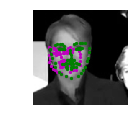

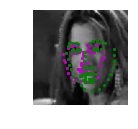

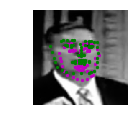

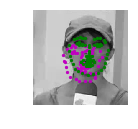

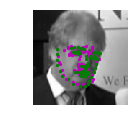

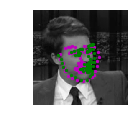

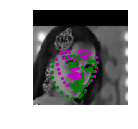

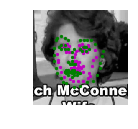

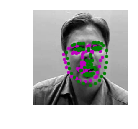

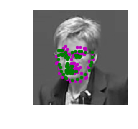

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

**Loss function** :  SmoothL1Loss as it is more suitable to regression where a  comparison is made between the predicted value and the target value. Also as mentioned in PyTorch docs: "It is less sensitive to outliers than the `MSELoss` and in some cases prevents exploding gradients"

**Optimizer** : Adam is a popular optimizer and empirically has shown good performance for most problems.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

Used Alexnet architecture with some minor changes. Dropout layers are added to avoid overfitting. Batchnorm layers also acts as a regularizer and also helps in faster training.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Initially decided to train for 20 epochs but the loss wasn't decreasing anymore and it was taking really long to complete a single epoch, so stopped at 10th epoch. Also, I have used a very low batch size of 10 which means we don't need to train for a lot more epochs. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.02078944 -0.01562056  0.0189651   0.01768709  0.00360781 -0.00839088
   0.00579322 -0.02711042 -0.04842738 -0.04448785 -0.04346963]
 [-0.00030057  0.03239033 -0.00567581  0.02459558  0.02584324  0.00173756
   0.0018388  -0.00388628 -0.00749585 -0.04949212 -0.04777719]
 [ 0.00104207  0.03519362  0.03918744  0.02328537  0.02581567  0.03699135
   0.00622661  0.00893016 -0.02598485 -0.02559925 -0.02665152]
 [ 0.03574109  0.03390552  0.01212394  0.00459338  0.01632922  0.02599253
   0.02638677 -0.00931866 -0.02193951  0.00301506 -0.04293717]
 [ 0.01298279  0.05169414  0.02012244  0.03364795  0.0032994   0.00268624
   0.02794705 -0.00811592 -0.01552668 -0.00996984 -0.01173184]
 [ 0.04885879  0.03826496  0.0321852   0.02604459  0.02660579  0.03218931
   0.0327062   0.00171965 -0.02069321 -0.02428903 -0.01613982]
 [ 0.03105796  0.03908373  0.07744873  0.05935977  0.01712474  0.01640888
   0.02477928  0.00330738  0.01989301 -0.01751425  0.00031807]
 [ 0.04333247  0.07492944  0.07625192  0.

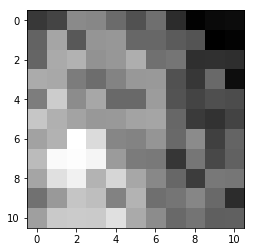

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

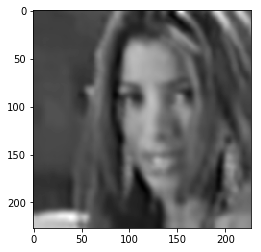

In [25]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2

idx = 1
img = np.squeeze(test_images[idx].data.numpy())
filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The image seemed to have blurred. The hidden layers definitely abstracts the information of the input image but it's not very clear what the first conv layer has done.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!